# 1. Import Libraries and Set Directory
---

Import Libraries

In [1]:
is_drive = 0

In [2]:
if is_drive==1 :
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# directory management
import os
from glob import glob
# regular imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# audio analysis
import librosa 
import librosa.display
import IPython.display as ipd
# imports for colors and plots
from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
# imports for NN
import tensorflow as tf
from tensorflow import keras
import time

# 3. Load Dataset and Training the Models
---

## 3.1. Loading Spectograms

In [4]:
# Spectogram Path
if is_drive==1 :   
    TRAIN_DIR = "/content/drive/MyDrive/spectogram-dataset/Train/"
    TEST_DIR = "/content/drive/MyDrive/spectogram-dataset/Test/"
else :
    TRAIN_DIR = "../Project/spectogram-dataset/Train/"
    TEST_DIR = "../Project/spectogram-dataset/Test/"

In [5]:
def load_fsdd(train_spectrograms_path,test_spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(train_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_train.append(spectrogram)
    x_train = np.array(x_train)        # -> (n_samples, n_bins, n_frames)
    x_train = x_train[..., np.newaxis] # -> (1200, 800, 32, 1)

    x_test  = []
    for root, _, file_names in os.walk(test_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_test.append(spectrogram)
    x_test = np.array(x_test)        # -> (n_samples, n_bins, n_frames)
    x_test = x_test[..., np.newaxis] # -> (300, 800, 32, 1)

    return x_train,x_test

In [6]:
x_train, x_test = load_fsdd(TRAIN_DIR, TEST_DIR)

## 3.2 Simple Flatten AE

In [7]:
from keras import layers

In [8]:
BATCH_SIZE = 32
EPOCHS = 15
print(x_train.shape)
print(x_test.shape)
# flatten the dataset
x_train_sm = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sm  = x_test .reshape((len(x_test ), np.prod(x_test .shape[1:])))
print(x_train_sm.shape)
print(x_test_sm.shape)

(1200, 160, 84, 1)
(300, 160, 84, 1)
(1200, 13440)
(300, 13440)


In [17]:
# the size of compression dimension
encoding_dim = 16
#input image
input_img = keras.Input(shape=(13440,), name="input_data_Flattened")
#encoded representation of the input
encoded = layers.Dense(encoding_dim,activation='relu', name="Encoder_output")(input_img)
# lossy reconstruction
decoded = layers.Dense(13440, activation="sigmoid", name="AE_output")(encoded)

simple_ae = keras.Model(inputs=input_img, outputs=decoded, name="Simple_AE")

simple_ae.summary()

Model: "Simple_AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data_Flattened (Input  [(None, 13440)]          0         
 Layer)                                                          
                                                                 
 Encoder_output (Dense)      (None, 16)                215056    
                                                                 
 AE_output (Dense)           (None, 13440)             228480    
                                                                 
Total params: 443,536
Trainable params: 443,536
Non-trainable params: 0
_________________________________________________________________


In [18]:
simple_ae_encoder = keras.Model(inputs=input_img, outputs=encoded)

In [19]:
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = simple_ae.layers[-1]
simple_ae_decoder = keras.Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [20]:
simple_ae.compile(optimizer='adam', loss='binary_crossentropy')

In [21]:
tic=time.time()
with tf.device('/GPU:1'):
    hist = simple_ae.fit( x_train_sm,x_train_sm,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        validation_data=(x_test_sm,x_test_sm))
toc=time.time()
training_time=toc-tic

Epoch 1/15
38/38 [==============================] - 6s 35ms/step - loss: 0.5477 - val_loss: 0.5059
Epoch 2/15
38/38 [==============================] - 1s 38ms/step - loss: 0.4837 - val_loss: 0.4991
Epoch 3/15
38/38 [==============================] - 1s 35ms/step - loss: 0.4775 - val_loss: 0.4923
Epoch 4/15
38/38 [==============================] - 1s 34ms/step - loss: 0.4712 - val_loss: 0.4886
Epoch 5/15
38/38 [==============================] - 1s 37ms/step - loss: 0.4654 - val_loss: 0.4838
Epoch 6/15
38/38 [==============================] - 1s 34ms/step - loss: 0.4596 - val_loss: 0.4804
Epoch 7/15
38/38 [==============================] - 1s 35ms/step - loss: 0.4553 - val_loss: 0.4775
Epoch 8/15
38/38 [==============================] - 1s 35ms/step - loss: 0.4528 - val_loss: 0.4758
Epoch 9/15
38/38 [==============================] - 1s 36ms/step - loss: 0.4509 - val_loss: 0.4748
Epoch 10/15
38/38 [==============================] - 1s 37ms/step - loss: 0.4497 - val_loss: 0.4737
Epoch 11/

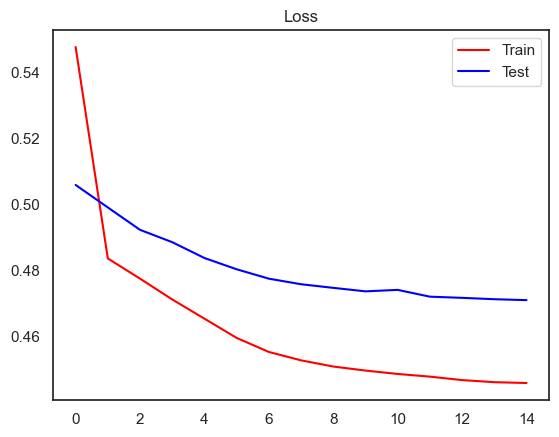

In [22]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.show()